In [1]:
import pandas as pd

import numpy as np

import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

import seaborn as sn

import random
import os

/home/ai/student24/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sequence_path = "../chr_seq/"
annotation_path = "../combined_annotations.csv"

In [3]:
annotations = pd.read_csv(annotation_path, sep='\t')

In [4]:
annotations['label'] = np.where(annotations['label'] == 'enhP', 'enhP', 'rest')

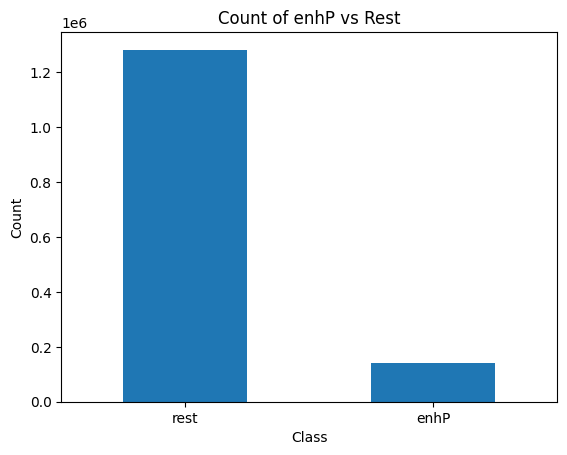

In [5]:
# Count the occurrences of each class
class_counts = annotations['label'].value_counts()
# Plot the counts
class_counts.plot(kind='bar')
plt.title('Count of enhP vs Rest')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Rotate x-axis labels to show them horizontally
plt.show()

In [6]:
num_enhP = len(annotations[annotations['label'] == 'enhP'])

junk_annotations_sampled = annotations[annotations['label'] == 'rest'].sample(n=num_enhP, random_state=42)

# Combine the two sets
annotations = pd.concat([annotations[annotations['label'] == 'enhP'], junk_annotations_sampled])

# Now you can proceed to create your dataset with 'balanced_annotations'
# instead of the full 'annotations' DataFrame

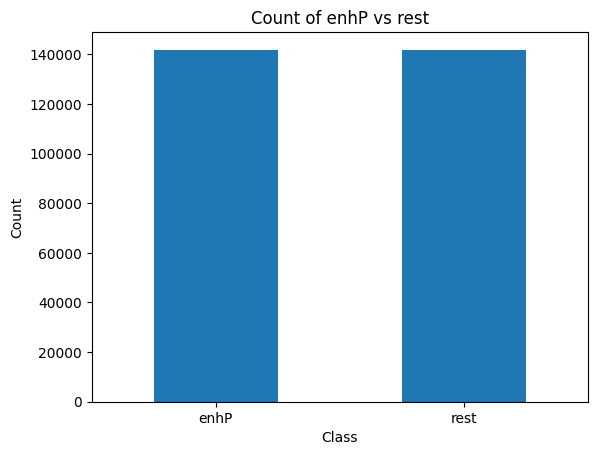

In [7]:
class_counts = annotations['label'].value_counts()

# Plot the counts
class_counts.plot(kind='bar')
plt.title('Count of enhP vs rest')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Rotate x-axis labels to show them horizontally
plt.show()



In [8]:
annotations.head()

,chrom,frameStart,frameEnd,label
0,chr1,181248,181648,enhP
6,chr1,779668,780068,enhP
16,chr1,817864,818264,enhP
18,chr1,818675,819075,enhP
22,chr1,826708,827108,enhP


In [9]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd


class DNADataset(Dataset):
    def __init__(self, sequence, annotations, encoding_type='integer'):
        self.sequence = sequence
        self.annotations = annotations
        self.encoding_type = encoding_type
        self.sections = self._extract_sections()
    
    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):     
        start, end, label = self.sections[index]
        sequence_section = self.sequence[start:end]
        sequence_section = [self._map_dna_letter(letter) for letter in sequence_section]
        sequence_section = torch.tensor(sequence_section).T
        
        return sequence_section, label
    
    def _extract_sections(self):
        sections = []
        # Iterate over each annotation
        for _, row in self.annotations.iterrows():
            start = row['frameStart']
            end = row['frameEnd']
            label = self._map_annotation_type(row['label'])
            sections.append((start, end, label))
        return sections

    def _map_dna_letter(self, letter):
        if self.encoding_type == 'integer':
            if letter == 'A':
                return 1
            elif letter == 'C':
                return 2
            elif letter == 'G':
                return 3
            elif letter == 'T':
                return 4
            elif letter == 'N':
                return 5
            else:
                raise ValueError(f"Invalid DNA letter: {letter}")
        elif self.encoding_type == 'one_hot':
            if letter == 'A':
                return [1, 0, 0, 0]
            elif letter == 'C':
                return [0, 1, 0, 0]
            elif letter == 'G':
                return [0, 0, 1, 0]
            elif letter == 'T':
                return [0, 0, 0, 1]
            elif letter == 'N':
                return [0, 0, 0, 0]
            else:
                raise ValueError(f"Invalid DNA letter: {letter}")
        else:
            raise ValueError(f"Invalid encoding type: {self.encoding_type}")
    
    @staticmethod
    def _map_annotation_type(annotation_type):
        if annotation_type == 'enhP':
            return 1
        elif annotation_type == 'rest':
            return 0

In [10]:
# Create a list of chromosome names including chrX and chrY
chr_sequences = [f'chr{i}' for i in range(1, 23)] + ['chrX', 'chrY']

dataset = []

for seq in chr_sequences:
    # Read DNA sequence file
    print(f'Processing {seq}...')
    sequence_file_path = f'{sequence_path}/{seq}.fa'
    annotations_for_seq = annotations[annotations['chrom'] == seq]
    print(f'Number of annotations for {seq}: {annotations_for_seq.shape[0]}')
    
    with open(sequence_file_path, 'r') as file:
        # Skip the first line which is the header
        next(file)
        # Read the sequence, remove newlines and convert to uppercase
        dna_sequence = file.read().replace("\n", "").upper()
        
        # Initialize the dataset for this chromosome with its annotations
        ds = DNADataset(dna_sequence, annotations_for_seq, encoding_type='one_hot')
        # Extend the main dataset with the data from this chromosome
        dataset.extend(ds)

# Split into training and testing sets (adjust ratios as per your needs)
train_size = int(0.9 * len(dataset))
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, len(dataset) - train_size])



Processing chr1...
Number of annotations for chr1: 26109
Processing chr2...
Number of annotations for chr2: 22199
Processing chr3...
Number of annotations for chr3: 17860
Processing chr4...
Number of annotations for chr4: 13280
Processing chr5...
Number of annotations for chr5: 15298
Processing chr6...
Number of annotations for chr6: 16250
Processing chr7...
Number of annotations for chr7: 14304
Processing chr8...
Number of annotations for chr8: 12737
Processing chr9...
Number of annotations for chr9: 11749
Processing chr10...
Number of annotations for chr10: 12823
Processing chr11...
Number of annotations for chr11: 14775
Processing chr12...
Number of annotations for chr12: 14814
Processing chr13...
Number of annotations for chr13: 7126
Processing chr14...
Number of annotations for chr14: 9609
Processing chr15...
Number of annotations for chr15: 9344
Processing chr16...
Number of annotations for chr16: 10061
Processing chr17...
Number of annotations for chr17: 13582
Processing chr18..

In [11]:
# # Save datasets
# torch.save(train_dataset, 'train_dataset.pt')
# torch.save(test_dataset, 'test_dataset.pt')


In [12]:
# train_dataset = torch.load('train_dataset.pt')
# test_dataset = torch.load('test_dataset.pt')

In [13]:
train_dataset.__len__()

255294

In [14]:
print(train_dataset.__getitem__(1))

(tensor([[0, 0, 1,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 1],
        [0, 1, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 1, 1, 0]]), 0)


In [15]:
# class CNN(nn.Module):
#     def __init__(self):
#         super(CNN, self).__init__()
#         self.conv1 = nn.Conv1d(4, 32, kernel_size=3, stride=1, padding=1)
#         self.pool1 = nn.MaxPool1d(kernel_size=2)
#         self.conv2 = nn.Conv1d(32, 32, kernel_size=3, stride=1, padding=1)
#         self.pool2 = nn.MaxPool1d(kernel_size=2)
#         self.flatten = nn.Flatten()
#         self.fc1 = nn.Linear(32 * 100, 100)
#         self.dropout = nn.Dropout(0.8)
#         self.fc2 = nn.Linear(100, 50)
#         self.fc3 = nn.Linear(50, 2)
#         # self.softmax = nn.Softmax(dim=1)

    
#     def forward(self, x):
#         x = self.pool1(nn.functional.relu(self.conv1(x)))
#         x = self.pool2(nn.functional.relu(self.conv2(x)))
#         x = self.flatten(x)
#         x = nn.functional.relu(self.fc1(x))
#         x = self.dropout(x)
#         x = nn.functional.relu(self.fc2(x))
#         x = self.fc3(x)
#         # x = self.softmax(x)
#         return x

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(4, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(2, 2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 50, 128)  # Assuming max pooling is applied 3 times
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 2)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.pool(nn.functional.relu(self.conv3(x)))
        x = self.flatten(x)
        x = nn.functional.relu(self.fc1(self.dropout(x)))
        x = nn.functional.relu(self.fc2(self.dropout(x)))
        x = self.fc3(x)
        return x


In [16]:
# Set random seed for reproducibility
torch.manual_seed(42)

# Define the training parameters
batch_size = 512
num_epochs = 20
learning_rate = 0.0001

# Create DataLoader instances for training and testing sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)




In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
device


/home/ai/student24/lib/python3.8/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11020). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


device(type='cpu')

Epoch 1/20:
Train Loss: 0.6499, Train Accuracy: 0.6135
Test Loss: 0.6295, Test Accuracy: 0.6416
ROC AUC: 0.6968

Epoch 2/20:
Train Loss: 0.6261, Train Accuracy: 0.6479
Test Loss: 0.6163, Test Accuracy: 0.6594
ROC AUC: 0.7150

Epoch 3/20:
Train Loss: 0.6175, Train Accuracy: 0.6596
Test Loss: 0.6160, Test Accuracy: 0.6605
ROC AUC: 0.7235

Epoch 4/20:
Train Loss: 0.6133, Train Accuracy: 0.6629
Test Loss: 0.6064, Test Accuracy: 0.6690
ROC AUC: 0.7274

Epoch 5/20:
Train Loss: 0.6098, Train Accuracy: 0.6668
Test Loss: 0.6039, Test Accuracy: 0.6707
ROC AUC: 0.7302

Epoch 6/20:
Train Loss: 0.6077, Train Accuracy: 0.6677
Test Loss: 0.6031, Test Accuracy: 0.6709
ROC AUC: 0.7319

Epoch 7/20:
Train Loss: 0.6051, Train Accuracy: 0.6708
Test Loss: 0.5994, Test Accuracy: 0.6729
ROC AUC: 0.7345

Epoch 8/20:
Train Loss: 0.6035, Train Accuracy: 0.6706
Test Loss: 0.6001, Test Accuracy: 0.6716
ROC AUC: 0.7359

Epoch 9/20:
Train Loss: 0.6020, Train Accuracy: 0.6715
Test Loss: 0.5967, Test Accuracy: 0.6738


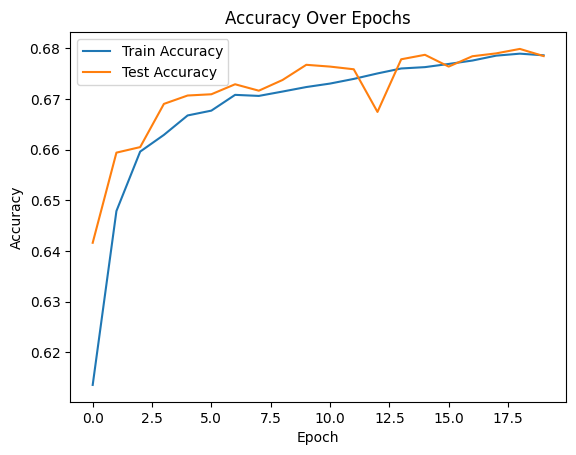

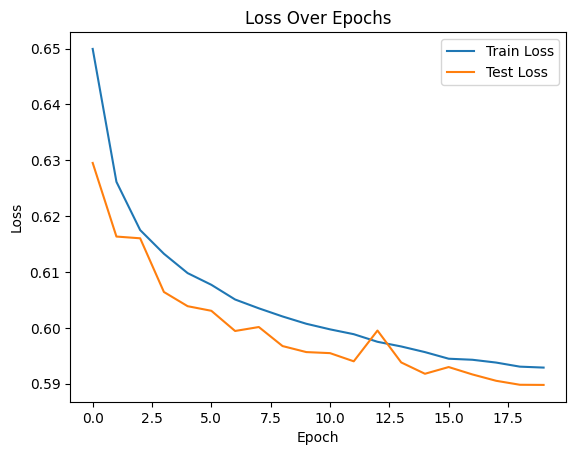

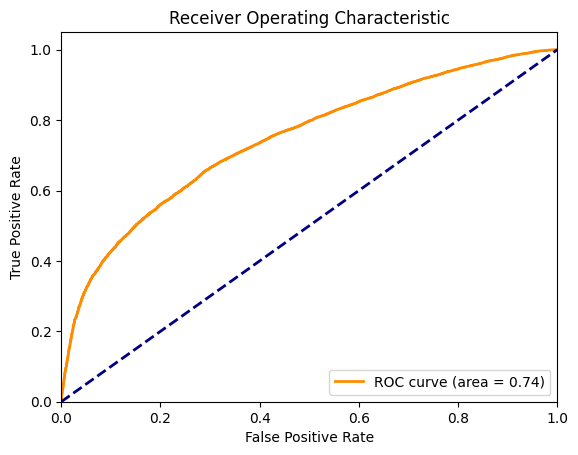

In [18]:
from sklearn.metrics import roc_curve, auc
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
# Create an instance of the CNN model
model = CNN()
model.to(device)
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
train_losses_per_epoch, train_accuracies_per_epoch = [], []
test_losses_per_epoch, test_accuracies_per_epoch = [], []
fpr_list, tpr_list, roc_auc_list = [], [], []  # For ROC curves

# Adjusted training loop
for epoch in range(num_epochs):
    model.train()
    total_loss, correct_predictions = 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.float().to(device), labels.long().to(device)
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()

    avg_train_loss = total_loss / len(train_loader.dataset)
    train_accuracy = correct_predictions / len(train_loader.dataset)
    train_losses_per_epoch.append(avg_train_loss)
    train_accuracies_per_epoch.append(train_accuracy)
    
    # Evaluate on test set after each epoch
    model.eval()
    total_loss, correct_predictions, all_targets, all_probabilities = 0, 0, [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.float().to(device), labels.long().to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()

            # For ROC curve
            probabilities = nn.functional.softmax(outputs, dim=1)[:, 1]
            all_probabilities.extend(probabilities.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())

    avg_test_loss = total_loss / len(test_loader.dataset)
    test_accuracy = correct_predictions / len(test_loader.dataset)
    test_losses_per_epoch.append(avg_test_loss)
    test_accuracies_per_epoch.append(test_accuracy)

    # Calculate ROC AUC
    fpr, tpr, _ = roc_curve(all_targets, all_probabilities)
    roc_auc = auc(fpr, tpr)
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    roc_auc_list.append(roc_auc)

    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}\n")

# Plot training and test accuracies
plt.plot(train_accuracies_per_epoch, label='Train Accuracy')
plt.plot(test_accuracies_per_epoch, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')
plt.show()

# Plot training and test losses
plt.plot(train_losses_per_epoch, label='Train Loss')
plt.plot(test_losses_per_epoch, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.show()

# Plot the ROC curve (using the last epoch's data)
plt.plot(fpr_list[-1], tpr_list[-1], color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_list[-1]:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Test Loss: 0.5898, Test Accuracy: 0.6785


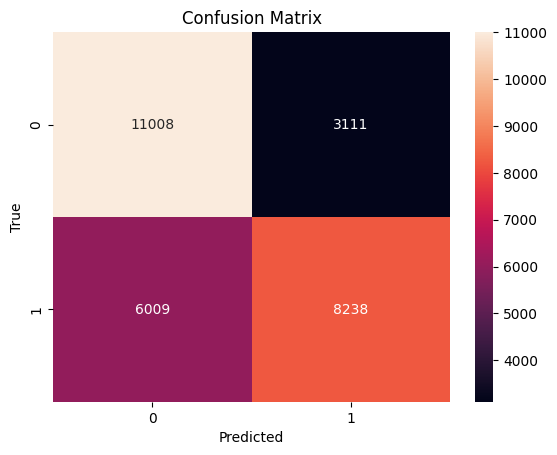

              precision    recall  f1-score   support

           0       0.65      0.78      0.71     14119
           1       0.73      0.58      0.64     14247

    accuracy                           0.68     28366
   macro avg       0.69      0.68      0.68     28366
weighted avg       0.69      0.68      0.68     28366



In [19]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

model.eval()  # Set the model to evaluation mode
total_loss = 0.0
correct_predictions = 0
all_predicted_labels = []
all_true_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.float().to(device), labels.long().to(device)
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        total_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct_predictions += (predicted == labels).sum().item()
        
        all_true_labels.extend(labels.cpu().numpy())
        all_predicted_labels.extend(predicted.cpu().numpy())

avg_loss = total_loss / len(test_loader.dataset)
accuracy = correct_predictions / len(test_loader.dataset)
# test_losses.append(avg_loss)
# test_accuracies.append(accuracy)

print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.4f}")

# Confusion matrix
confusion_mtx = confusion_matrix(all_true_labels, all_predicted_labels)
sns.heatmap(confusion_mtx, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(all_true_labels, all_predicted_labels))

# Suggestions for further improvements in elegance:
# 1. Function Definitions: Consider defining functions for repetitive tasks like plotting or calculating metrics.
# 2. Early Stopping: Implement early stopping during training to prevent overfitting.
# 3. Logging: Use a logging library instead of print statements for better control over the logging level and formatting.



In [20]:
class_counts

label
enhP    141830
rest    141830
Name: count, dtype: int64